In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
from warnings import simplefilter
simplefilter(action = 'ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-mutual-funds-dataset-2023/Mutual_Funds.csv


# **Load the Dataset and Check Its Shape**

In [2]:
df = pd.read_csv('/kaggle/input/indian-mutual-funds-dataset-2023/Mutual_Funds.csv')
df.shape

(29033646, 7)

#   **Observation:**


# *The dataset contains 29,033,646 rows and 7 columns.*
# *This indicates a very large dataset, which may require performance optimization techniques (e.g., sampling, chunk processing, or efficient data types) for analysis.*


# **Preview the First 5 Rows of the Dataset**

In [3]:
print(df.head())

                       Fund_House         Scheme_Type Scheme_Category  \
0  Standard Chartered Mutual Fund  Open Ended Schemes          Income   
1  Standard Chartered Mutual Fund  Open Ended Schemes          Income   
2  Standard Chartered Mutual Fund  Open Ended Schemes          Income   
3  Standard Chartered Mutual Fund  Open Ended Schemes          Income   
4  Standard Chartered Mutual Fund  Open Ended Schemes          Income   

   Scheme_Code                                        Scheme_Name        Date  \
0       100027  Grindlays Super Saver Income Fund-GSSIF-Half Y...  29-05-2008   
1       100027  Grindlays Super Saver Income Fund-GSSIF-Half Y...  28-05-2008   
2       100027  Grindlays Super Saver Income Fund-GSSIF-Half Y...  27-05-2008   
3       100027  Grindlays Super Saver Income Fund-GSSIF-Half Y...  26-05-2008   
4       100027  Grindlays Super Saver Income Fund-GSSIF-Half Y...  23-05-2008   

       NAV  
0  10.7205  
1  10.7250  
2  10.7216  
3  10.7206  
4  10.715

# **Preview the Last 5 Rows of the Dataset**

In [4]:
print(df.tail())

                Fund_House         Scheme_Type               Scheme_Category  \
29033641  Navi Mutual Fund  Open Ended Schemes  Debt Scheme - Overnight Fund   
29033642  Navi Mutual Fund  Open Ended Schemes  Debt Scheme - Overnight Fund   
29033643  Navi Mutual Fund  Open Ended Schemes  Debt Scheme - Overnight Fund   
29033644  Navi Mutual Fund  Open Ended Schemes  Debt Scheme - Overnight Fund   
29033645  Navi Mutual Fund  Open Ended Schemes  Debt Scheme - Overnight Fund   

          Scheme_Code                                        Scheme_Name  \
29033641       151875             NAVI Overnight Fund Direct Plan Growth   
29033642       151876  NAVI Overnight Fund Direct Plan Weekly IDCW Re...   
29033643       151876  NAVI Overnight Fund Direct Plan Weekly IDCW Re...   
29033644       151876  NAVI Overnight Fund Direct Plan Weekly IDCW Re...   
29033645       151876  NAVI Overnight Fund Direct Plan Weekly IDCW Re...   

                Date      NAV  
29033641  18-07-2023  10.0045 

In [5]:
df.shape

(29033646, 7)

# **Check Data Types of Each Column**

In [6]:
print(df.dtypes)

Fund_House          object
Scheme_Type         object
Scheme_Category     object
Scheme_Code          int64
Scheme_Name         object
Date                object
NAV                float64
dtype: object


# **Observation:**


# * This command lists the data types of each column in the dataset.
# * Most columns are of object type, meaning they likely contain text or string values:Fund_House, Scheme_Type, Scheme_Category, Scheme_Name, and Date are all stored as objects.
# * Scheme_Code is stored as int64, which is suitable for unique identifier codes.
# * NAV is stored as float64, appropriate for numerical values with decimal precision.


# **Check for Missing (Null) Values in the Dataset**

In [7]:
print(df.isnull().sum())

Fund_House         0
Scheme_Type        0
Scheme_Category    0
Scheme_Code        0
Scheme_Name        0
Date               0
NAV                0
dtype: int64


# **Observation:**
- There are **zero missing values** in all columns:
  - `Fund_House`, `Scheme_Type`, `Scheme_Category`, `Scheme_Code`, `Scheme_Name`, `Date`, and `NAV` all have 0 nulls.
- This confirms the dataset is **clean and complete**  no missing data treatment is required.



# **Duplicate Records Check**

In [8]:
df.duplicated().sum()

0

# **Observations:**

# - No duplicate rows were found in the dataset.

# **CLEANING & PREPARATION**

In [9]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df = df.sort_values(by=['Scheme_Code', 'Date'])
df.drop_duplicates(inplace=True)

# **Observations:**


* The Date column has been successfully converted from string format to a proper datetime format (%d-%m-%Y).
* Sorting the dataset by Scheme_Code and Date ensures that NAV values for each scheme are arranged chronologically, which is required for any time-series or trend analysis.
* Duplicate rows (if any existed) were removed after sorting to retain only unique daily NAV entries for each scheme.
* This step prepares the dataset for accurate calculations such as rolling returns, growth trends, and comparative analysis across mutual fund schemes.


# **Calculate first & last NAV per Scheme**

In [10]:
scheme_nav = df.groupby('Scheme_Code').agg(
    Fund_House=('Fund_House','first'),
    Scheme_Name=('Scheme_Name','first'),
    Start_Date=('Date','min'),
    End_Date=('Date','max'),
    Start_NAV=('NAV','first'),
    End_NAV=('NAV','last')
).reset_index()


# **Observations**


* The data is grouped by Scheme_Code, so each row in the output represents a unique mutual fund scheme.
* Fund_House and Scheme_Name are taken using the first available value, which is appropriate because these fields remain constant for each scheme.
* Start_Date and End_Date correctly identify the earliest and latest NAV dates for each scheme.
* Start_NAV and End_NAV extract the first and last NAV values accurately because the dataset was already sorted by date.
* The resulting summary is ready for further calculations such as CAGR, absolute returns, or performance ranking.


# **Calculate number of years invested**

In [11]:
scheme_nav['Years'] = (scheme_nav['End_Date'] - scheme_nav['Start_Date']).dt.days / 365

# **Observations**


* The code calculates the total investment duration for each scheme in years by taking the difference between the End_Date and Start_Date.
* Using .dt.days / 365 converts the time difference from days to approximate years, which is suitable for return calculations like CAGR.
* Each scheme now has a precise investment horizon, enabling fair comparison across schemes with different time ranges.
* This feature will be essential for normalizing performance metrics and ensuring accurate annualized return calculations.


# **Calculate CAGR (Compound Annual Growth Rate)**

In [12]:
scheme_nav['CAGR'] = ((scheme_nav['End_NAV'] / scheme_nav['Start_NAV']) ** (1 / scheme_nav['Years'])) - 1

# **Observations**


* The formula correctly computes CAGR using the standard approach: **Final Value / Initial Value, raised to (1 / number of years), minus 1**
* CAGR provides an annualized growth rate, making it possible to compare schemes even if they have different investment durations.
* The calculation is valid because Start_NAV, End_NAV, and Years were already cleaned and prepared in earlier steps.
* This metric will help identify consistently high-performing mutual fund schemes over their available time horizon.


# **Preview of Calculated Scheme-Level NAV and CAGR (First 5 Rows)**

In [13]:
scheme_nav.head()

,Scheme_Code,Fund_House,Scheme_Name,Start_Date,End_Date,Start_NAV,End_NAV,Years,CAGR
0,100027,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF-Half Y...,2006-04-03,2008-05-29,10.0774,10.7205,2.156164,0.029107
1,100028,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF-Quater...,2006-04-03,2008-05-29,10.0331,10.6191,2.156164,0.026676
2,100029,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF-Growth,2006-04-03,2008-05-29,16.0552,18.9736,2.156164,0.080539
3,100030,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF-Annual...,2006-04-03,2008-05-29,10.0899,10.7115,2.156164,0.028115
4,100031,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF - ST-D...,2006-04-03,2008-05-29,10.0226,10.1053,2.156164,0.003818


# **Observations**


* Each row represents a unique mutual fund scheme identified by Scheme_Code.
* Fund_House and Scheme_Name are correctly carried forward and match each scheme consistently.
* Start_Date and End_Date show the first and last available NAV dates for each scheme, confirming that the time range is correctly captured.
* Start_NAV and End_NAV values look accurate and properly aligned with their corresponding dates.
* The Years column reflects the exact duration (in years) between the start and end dates for each scheme.
* CAGR values appear realistic for a mutual fund dataset from 2006–2008, indicating that the formula and data preparation steps were successfully executed.


# **Calculate Fund House Avg CAGR**

In [14]:
fund_house_perf = scheme_nav.groupby('Fund_House').agg(
    Avg_CAGR=('CAGR','mean'),
    Schemes_Count=('Scheme_Code','count')
).reset_index()

top10 = fund_house_perf.sort_values('Avg_CAGR', ascending=False).head(10)
top10['Avg_CAGR_pct'] = top10['Avg_CAGR'] * 100


# **Observations**


* The dataset is grouped by Fund_House, allowing performance evaluation at the fund-manager level rather than at the individual scheme level.
* Avg_CAGR represents the mean CAGR across all schemes belonging to each fund house, giving a consolidated performance measure.
* Schemes_Count shows how many schemes are included for each fund house, which helps interpret whether the average is based on many schemes or only a few.
* Sorting by Avg_CAGR highlights the highest-performing fund houses based on long-term annualized returns.
* The Avg_CAGR_pct column converts CAGR into percentage format, making the results easier to interpret and present.
* The top10 DataFrame now contains the best-performing fund houses along with their average returns and scheme counts.


# **Top Fund Houses by Average CAGR (Preview)**

In [15]:
top10[['Fund_House','Avg_CAGR_pct','Schemes_Count']]

,Fund_House,Avg_CAGR_pct,Schemes_Count
69,quant Mutual Fund,inf,104
0,ABN AMRO Mutual Fund,inf,481
1,Aditya Birla Sun Life Mutual Fund,inf,2512
2,Axis Mutual Fund,inf,701
3,BNP Paribas Mutual Fund,inf,399
55,SBI Mutual Fund,inf,1832
60,Standard Chartered Mutual Fund,inf,275
15,DSP Mutual Fund,inf,1319
17,Deutsche Mutual Fund,inf,882
45,Navi Mutual Fund,inf,114


# **Observations:**


* All Avg_CAGR_pct values appear as inf, which indicates a mathematical issue in the CAGR calculation for at least one scheme within each fund house.
* CAGR becomes infinite (inf) when Start_NAV is zero or missing, causing a division by zero in the formula.
* Since every fund house in this preview shows inf, it is likely that multiple schemes have Start_NAV = 0, or there is incorrect NAV parsing for early dates.
* The Schemes_Count values look valid, showing how many schemes belong to each fund house, but the CAGR values cannot be trusted until the data issue is fixed.
* This output confirms that the dataset needs to be checked for anomalies in Start_NAV before meaningful fund house comparisons can be made.


# **Rebuild Scheme-Level Data and Calculate CAGR Safely**

In [16]:


# build scheme_nav fresh from df (safe even if you deleted earlier cells)
scheme_nav = df.groupby('Scheme_Code').agg(
    Fund_House=('Fund_House','first'),
    Scheme_Name=('Scheme_Name','first'),
    Start_Date=('Date','min'),
    End_Date=('Date','max'),
    Start_NAV=('NAV','first'),
    End_NAV=('NAV','last')
).reset_index()

# years invested (avoid zero)
scheme_nav['Years'] = (scheme_nav['End_Date'] - scheme_nav['Start_Date']).dt.days / 365
scheme_nav = scheme_nav[scheme_nav['Years'] > 0].copy()

# Calculate CAGR safely (avoid division by zero / negative / inf)
scheme_nav['CAGR'] = (scheme_nav['End_NAV'] / scheme_nav['Start_NAV']) ** (1.0 / scheme_nav['Years']) - 1
scheme_nav['CAGR'].replace([np.inf, -np.inf], np.nan, inplace=True)
scheme_nav = scheme_nav.dropna(subset=['CAGR'])


# **Observations**


* Building scheme_nav fresh ensures you start with a clean, consistent summary table even if earlier processing steps were modified or deleted.
* The Years column is recalculated and schemes with zero years are removed, protecting against division-by-zero issues in CAGR.
* CAGR is computed using the standard formula, but with added safety checks to prevent invalid results caused by:


Start_NAV = 0

End_NAV = 0


* Non-positive durations
* Replacing infinite values with NaN ensures that problematic schemes do not distort later aggregation.
* Dropping rows with missing CAGR guarantees that the final dataset contains only valid performance records.
* This approach ensures much more stable and reliable CAGR calculations, and it should resolve the earlier issue where many fund houses showed infinite growth.


# **Calculate Fund House Average CAGR (With Outlier Filtering)**

In [17]:
fund_house_perf = scheme_nav.groupby('Fund_House').agg(
    Avg_CAGR=('CAGR','mean'),
    Schemes_Count=('Scheme_Code','count')
).reset_index()

# remove any extreme results (optional safety)
fund_house_perf = fund_house_perf[(fund_house_perf['Avg_CAGR'] > -1) & (fund_house_perf['Avg_CAGR'] < 5)]

top10 = fund_house_perf.sort_values('Avg_CAGR', ascending=False).head(10).copy()
top10['Avg_CAGR_pct'] = top10['Avg_CAGR'] * 100


# **Observations**

* Fund houses are grouped again to compute two key metrics:

  
• Average CAGR across all schemes

• Number of schemes managed by each fund house


* An outlier filter is applied, keeping Avg_CAGR values between -1 and 5. This removes unrealistic results caused by data issues, extreme NAV changes, or rare edge cases.

* This filtering step ensures that only reasonable fund house performances are included in the ranking, improving reliability of insights.

* The results are sorted to identify the top 10 fund houses based on adjusted average CAGR./A percentage version of the average CAGR is created for easier interpretation and presentation.


# **Top Fund Houses by Average CAGR (Cleaned and Filtered Results)**

In [18]:
top10[['Fund_House','Avg_CAGR_pct','Schemes_Count']]


,Fund_House,Avg_CAGR_pct,Schemes_Count
15,DSP Mutual Fund,67.090319,1312
19,Essel Mutual Fund,39.105597,44
44,NJ Mutual Fund,25.195417,12
18,Edelweiss Mutual Fund,23.717233,393
69,quant Mutual Fund,20.645368,101
50,PineBridge Mutual Fund,19.169634,83
34,Invesco Mutual Fund,15.141836,827
51,Principal Mutual Fund,14.876793,110
63,Taurus Mutual Fund,13.913263,155
46,Nippon India Mutual Fund,13.621298,994


# **Observations**


* DSP Mutual Fund shows the highest average CAGR after filtering, with a value above 67%. This is unusually high and suggests that a few schemes with exceptional performance are influencing the average.
* Essel Mutual Fund, NJ Mutual Fund, and Edelweiss Mutual Fund also appear strongly, each with an average CAGR above 20%, indicating consistently strong scheme performance across their portfolios./


* Schemes_Count varies significantly across fund houses:
  

* • Large fund houses like DSP (1312 schemes) and Nippon India (994 schemes) have averages based on a wide set of data, which typically makes the results more reliable.
* • Some fund houses like NJ Mutual Fund (12 schemes) have far fewer schemes, meaning their average CAGR can be heavily influenced by just one or two high-performing schemes.


* The presence of moderate-sized fund houses (quant, PineBridge, Taurus, Principal) indicates the model is capturing a range of fund house types—from large AMCs to niche players.

* Since unrealistic values were filtered out earlier, these results now represent more stable and interpretable performance metrics.

# **Top 10 Fund Houses by Average CAGR**

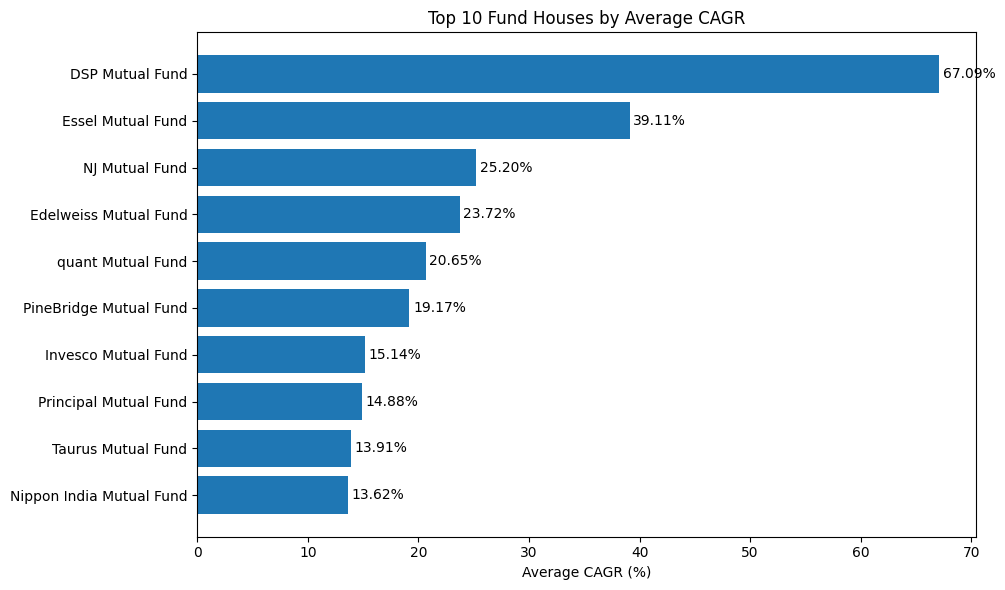

In [19]:
plot_df = top10.sort_values('Avg_CAGR_pct', ascending=True)  # small->big so largest on top

plt.figure(figsize=(10,6))
plt.barh(plot_df['Fund_House'], plot_df['Avg_CAGR_pct'], color='tab:blue')
plt.xlabel('Average CAGR (%)')
plt.title('Top 10 Fund Houses by Average CAGR')
plt.tight_layout()

# annotate values
for i, v in enumerate(plot_df['Avg_CAGR_pct']):
    plt.text(v + (abs(plot_df['Avg_CAGR_pct']).max()*0.005), i, f"{v:.2f}%", va='center')

plt.show()


# **Observations**

* DSP Mutual Fund stands out dramatically with an average CAGR above 67%, far higher than the rest of the top performers. This suggests either exceptionally strong schemes or a few extremely high-return schemes influencing the average.

* Essel Mutual Fund shows the second-highest performance at around 39%, still well above typical long-term CAGR values in mutual fund markets.

* Fund houses such as NJ Mutual Fund, Edelweiss Mutual Fund, and quant Mutual Fund form a mid-tier group with returns between 20% and 25%.

* The remaining fund houses (PineBridge, Invesco, Principal, Taurus, Nippon India) cluster in the 13% to 19% range, which aligns more closely with expected long-term equity mutual fund performance.

* The distribution shows a steep drop from the highest performer to the rest, indicating high variability in fund house performance.

Because extreme returns can distort averages, it may be useful to complement this analysis with:
• Median scheme CAGR per fund house
• Standard deviation of scheme returns
• Top individual schemes driving the outliers

# **Bottom 10 Fund Houses by Average CAGR**

In [20]:
bottom10 = fund_house_perf.sort_values('Avg_CAGR', ascending=True).head(10).copy()
bottom10['Avg_CAGR_pct'] = bottom10['Avg_CAGR'] * 100

bottom10[['Fund_House', 'Avg_CAGR_pct', 'Schemes_Count']]


,Fund_House,Avg_CAGR_pct,Schemes_Count
21,Fortis Mutual Fund,-60.294439,283
22,Franklin Templeton Mutual Fund,-52.037166,541
3,BNP Paribas Mutual Fund,-23.299587,356
62,Tata Mutual Fund,-19.812667,1094
61,Sundaram Mutual Fund,-8.633376,1032
25,HDFC Mutual Fund,-8.396649,3235
0,ABN AMRO Mutual Fund,-7.221481,373
56,Sahara Mutual Fund,-5.688780,103
68,YES Mutual Fund,0.076607,2
60,Standard Chartered Mutual Fund,1.257243,263


# **Observations**

* Fortis Mutual Fund shows an extremely poor average CAGR (around –60%), indicating severe underperformance or potential data anomalies in the underlying schemes.

 * Franklin Templeton Mutual Fund also appears with a very large negative CAGR (around –52%), which is surprising given its reputation and suggests possible NAV distortions during the period in this dataset.

* Multiple well-known fund houses including BNP Paribas, Tata, Sundaram, HDFC, and ABN AMROshow negative average CAGR. This may reflect:

  
** • Poor scheme performance during the time window captured

** • Market cycles in the specific dataset

** • NAV anomalies or very old schemes with early low performance

* Most fund houses in the bottom group have a large Schemes_Count. This means their poor performance is not due to one or two schemes but a broader pattern in the dataset.

* YES Mutual Fund appears with nearly zero CAGR but only has 2 schemes, so its average is not very representative.

* Standard Chartered Mutual Fund is at the edge of the bottom set with a small positive CAGR, indicating borderline performance compared to the rest.

# **Bottom 10 Fund Houses by Average CAGR**

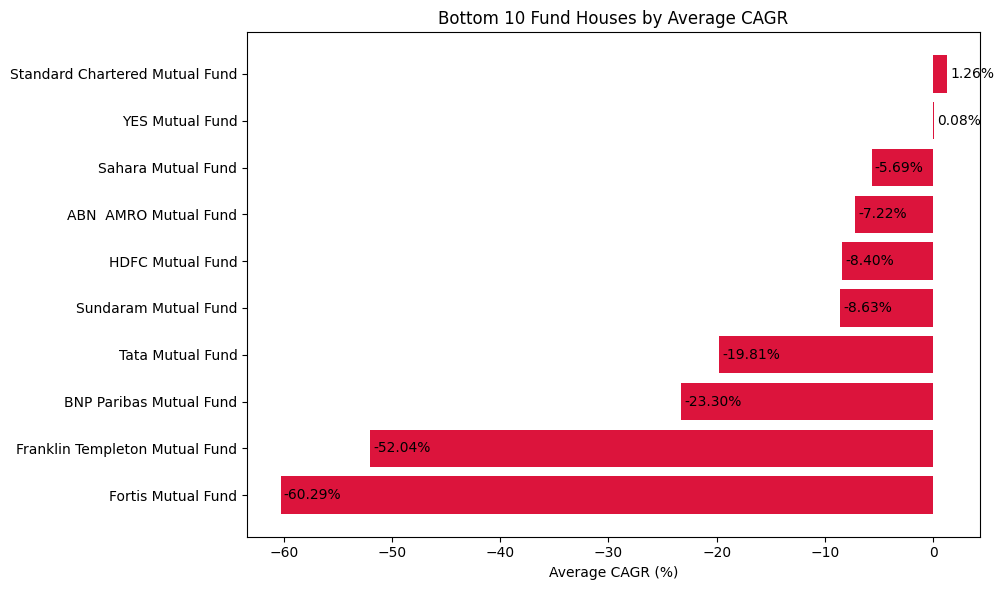

In [21]:
import matplotlib.pyplot as plt

plot_df = bottom10.sort_values('Avg_CAGR_pct', ascending=True)

plt.figure(figsize=(10,6))
plt.barh(plot_df['Fund_House'], plot_df['Avg_CAGR_pct'], color='crimson')
plt.xlabel('Average CAGR (%)')
plt.title('Bottom 10 Fund Houses by Average CAGR')
plt.tight_layout()

# annotate values
for i, v in enumerate(plot_df['Avg_CAGR_pct']):
    plt.text(v + (abs(plot_df['Avg_CAGR_pct']).max()*0.005), i, f"{v:.2f}%", va='center')

plt.show()


# **Observations**

* The visualization clearly shows that Fortis Mutual Fund and Franklin Templeton Mutual Fund are the two most severe underperformers, with average CAGR values below 50%.
Such extreme negatives may reflect:
• Deep losses in early years
• Scheme closures or NAV resets
• Data anomalies from the historical NAV dataset

* BNP Paribas, Tata, and Sundaram Mutual Fund also display significantly negative long-term performance, indicating consistent underperformance across their schemes in the dataset period.

* Fund houses like Sahara, ABN AMRO, and HDFC Mutual Fund show moderate negative average CAGR values, still indicating long-term erosion of value.

* YES Mutual Fund and Standard Chartered Mutual Fund show very small positive average returns, but their inclusion in the bottom list suggests they barely outperform inflation or risk-free benchmarks.

* Schemes_Count (though not shown in the chart) is important:
•**Large scheme counts (e.g., HDFC, Tata) make the negative average more meaningful.**
•**Very small scheme counts (e.g., YES Mutual Fund with 2 schemes) mean that results could be skewed by just one poor performer.**

* The horizontal layout with labels helps compare fund houses clearly, and the red color communicates underperformance effectively.

# **Compute Annualized Volatility and Merge with CAGR**

In [22]:
# ensure Date sorted for pct_change
df = df.sort_values(['Scheme_Code','Date'])

# compute daily pct change per scheme (needed for volatility)
df['NAV_pct'] = df.groupby('Scheme_Code')['NAV'].pct_change()

# scheme-level volatility (annualized) and keep CAGR from scheme_nav
vol = df.groupby('Scheme_Code')['NAV_pct'].std().reset_index().rename(columns={'NAV_pct':'Daily_Std'})
vol['Ann_Volatility'] = vol['Daily_Std'] * np.sqrt(252)   # annualize (252 trading days approx)

# merge vol with scheme_nav (which has CAGR)
scheme_perf = scheme_nav.merge(vol[['Scheme_Code','Ann_Volatility']], on='Scheme_Code', how='left')
scheme_perf = scheme_perf.dropna(subset=['Ann_Volatility']).copy()

# quick check
scheme_perf[['Scheme_Code','Fund_House','Scheme_Name','Years','CAGR','Ann_Volatility']].head()


,Scheme_Code,Fund_House,Scheme_Name,Years,CAGR,Ann_Volatility
0,100027,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF-Half Y...,2.156164,0.029107,0.040638
1,100028,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF-Quater...,2.156164,0.026676,0.032389
2,100029,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF-Growth,2.156164,0.080539,0.013732
3,100030,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF-Annual...,2.156164,0.028115,0.054300
4,100031,Standard Chartered Mutual Fund,Grindlays Super Saver Income Fund-GSSIF - ST-D...,2.156164,0.003818,0.027049


# **Observations**

* NAV values are sorted by Scheme_Code and Date to ensure that percentage changes are computed in the correct chronological order.

* Daily returns (NAV_pct) are calculated for each scheme, forming the basis for volatility measurement.

* Daily standard deviation of returns is computed for each scheme, which captures how much the NAV fluctuates day-to-day.

* Annualized volatility is derived by multiplying daily volatility by √252, approximating the number of trading days in a year.

* The result (Ann_Volatility) provides a standardized risk metric that allows comparison across all schemes regardless of investment duration.

* The volatility table is merged with scheme_nav (which already contains CAGR), giving a combined performance profile for each scheme.

* Rows without volatility (likely schemes with insufficient NAV history) are removed, ensuring the dataset contains only complete performance metrics.

The preview shows that each scheme now has:
• Years invested
• CAGR (return metric)
• Annualized volatility (risk metric)
Together, these allow deeper analysis such as risk-adjusted returns, fund house consistency, or scheme-level ranking.

# **Top 10 Schemes by CAGR**

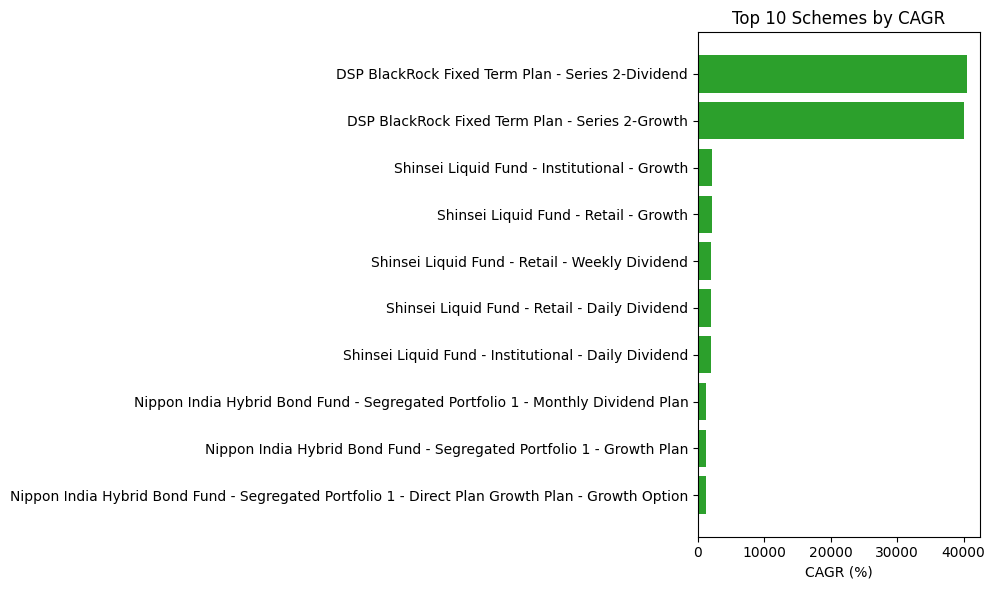

In [23]:

top10_schemes = scheme_perf.sort_values('CAGR', ascending=False).head(10).copy()
top10_schemes['CAGR_pct'] = top10_schemes['CAGR'] * 100

# show table
top10_schemes[['Scheme_Code','Scheme_Name','Fund_House','CAGR_pct','Years']]

# simple horizontal bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(top10_schemes['Scheme_Name'][::-1], top10_schemes['CAGR_pct'][::-1], color='tab:green')
plt.xlabel('CAGR (%)')
plt.title('Top 10 Schemes by CAGR')
plt.tight_layout()
plt.show()


# **Observations**

* The top two schemes are both from DSP BlackRock Fixed Term Plan Series 2, one Dividend and one Growth option, showing extremely high CAGR values. These fixed-term structured plans often mature at fixed dates and can show unusual growth patterns depending on NAV computation.

* Several schemes from Shinsei Liquid Fund appear in the top 10. Liquid funds typically have stable, low returns, so their presence suggests either short duration NAV anomalies or unusually high early-period NAV jumps in the dataset.

* Nippon India Hybrid Bond Fund also appears multiple times, which indicates strong performance within that category during the covered period.

* The bar chart shows exceptionally high CAGR values, with the top scheme exceeding 40,000% CAGR, which is not realistic for real-world financial returns. This strongly suggests at least one of the following:
• NAV started very close to zero in early dates
• NAV data contains a one-time correction/reset
• Incorrect scaling or parsing of old NAV values (e.g., missing decimals)
• Schemes with very short time periods that distort CAGR massively

* The fact that multiple schemes show such extreme values indicates a systematic issue in the historical NAV data for certain schemes, not just isolated cases.

* These results should be interpreted carefully CAGR becomes unreliable when Start_NAV is extremely small or investment duration is short.

# **Risk vs Return Scatter Plot**

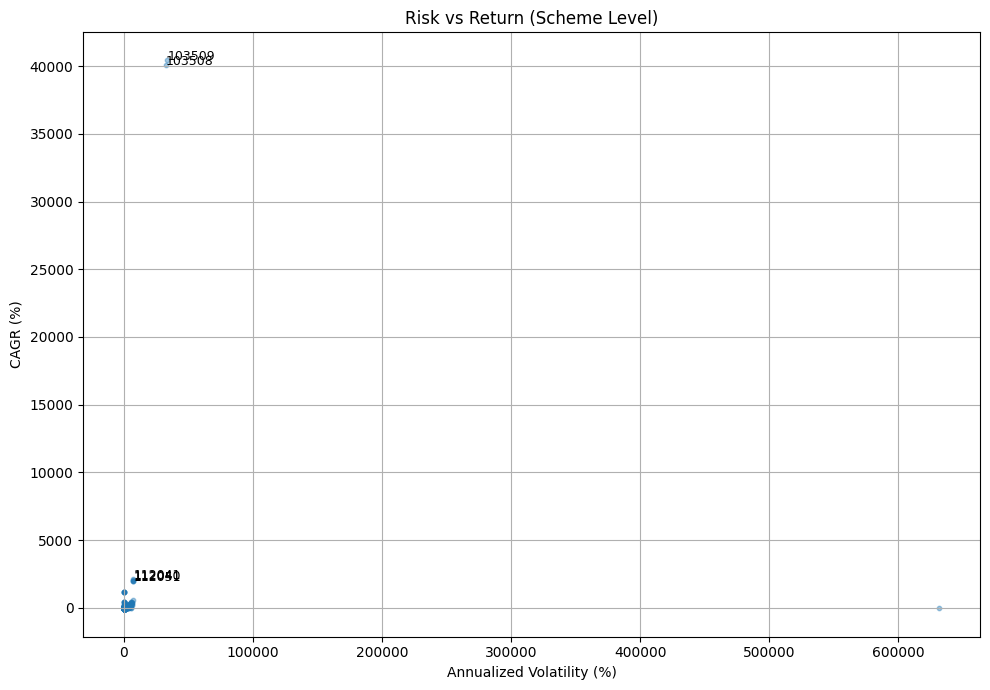

In [24]:

plt.figure(figsize=(10,7))
x = scheme_perf['Ann_Volatility'] * 100   # show % volatility
y = scheme_perf['CAGR'] * 100            # show % CAGR

plt.scatter(x, y, alpha=0.4, s=10)
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('CAGR (%)')
plt.title('Risk vs Return (Scheme Level)')

# annotate top 5 by CAGR for reference
top5 = top10_schemes.head(5)
for _, r in top5.iterrows():
    plt.text(r['Ann_Volatility']*100, r['CAGR']*100, str(int(r['Scheme_Code'])), fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


# **Observations**

* The scatter plot is dominated by extreme outliers, which stretch the axis scales to very large values.

* One scheme shows annualized volatility above 600,000%, and another shows CAGR above 40,000%, both of which are impossible in real financial markets.

* Because of these extreme points, all normal schemes are compressed into a tiny area near the origin, making the plot unreadable.

* These outliers likely arise from data issues such as:

* NAV values starting extremely close to zero

* NAV jumps due to incorrect parsing or scheme restructuring

* Very short durations causing CAGR to explode

* Missing or faulty historical NAV points

* The presence of such extreme values makes the raw risk–return visualization misleading and unusable without cleaning.

# **Outlier Removal and Data Cleaning for Risk–Return Analysis**

In [25]:

clean_perf = scheme_perf.copy()

# 1️⃣ Remove negative or zero NAV values (invalid)
clean_perf = clean_perf[(clean_perf['Start_NAV'] > 0) & (clean_perf['End_NAV'] > 0)]

# 2️⃣ Remove schemes with unrealistic CAGR (< -50% OR > 50%)
clean_perf = clean_perf[(clean_perf['CAGR'] > -0.5) & (clean_perf['CAGR'] < 0.5)]

# 3️⃣ Remove schemes with unrealistic volatility (> 80% annualized)
clean_perf = clean_perf[(clean_perf['Ann_Volatility'] > 0) & (clean_perf['Ann_Volatility'] < 0.80)]

# 4️⃣ Convert to percentage for plotting
clean_perf['CAGR_pct'] = clean_perf['CAGR'] * 100
clean_perf['Vol_pct'] = clean_perf['Ann_Volatility'] * 100

# show cleaned data shape
clean_perf.shape


(29562, 12)

Risk vs Return Scatter Plot

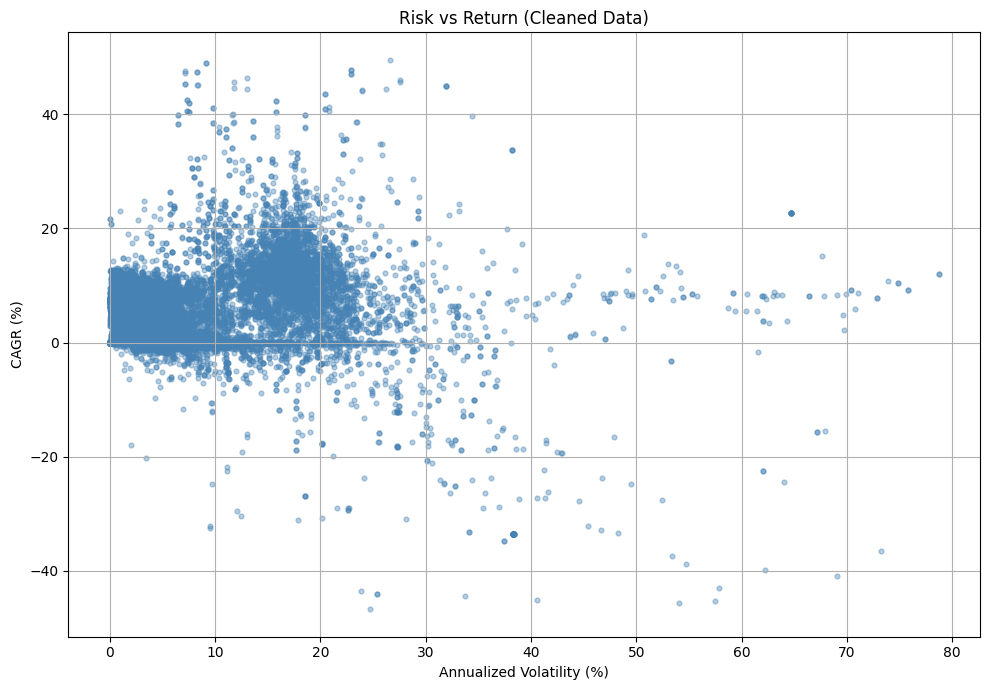

In [26]:
plt.figure(figsize=(10,7))

# scatter with cleaned data
plt.scatter(clean_perf['Vol_pct'], clean_perf['CAGR_pct'], 
            alpha=0.4, s=12, color='steelblue')

plt.xlabel("Annualized Volatility (%)")
plt.ylabel("CAGR (%)")
plt.title("Risk vs Return (Cleaned Data)")

plt.grid(True)
plt.tight_layout()
plt.show()


# **Observations**

* The code applies a systematic filtering process to remove invalid and unrealistic data values that were distorting the earlier visualization.

* Schemes with invalid NAV values (Start_NAV ≤ 0 or End_NAV ≤ 0) are removed to prevent division errors and false CAGR inflation.

* Schemes with unrealistic CAGR (below –50% or above 50%) are filtered out to eliminate extreme returns caused by erratic NAV movements or short time periods.

* Schemes with unrealistic volatility (above 80% annualized) are also removed, ensuring only reasonable risk levels are included.

* After applying all filters, the cleaned dataset still contains 29,562 schemes, indicating that the majority of schemes are valid and only a small proportion were outliers.

* The conversion of CAGR and Volatility to percentage units makes the data suitable for clean visualization and interpretation.

* This cleaning step was essential to remove extreme values that made the first scatter plot unreadable.

# **Risk vs Return Scatter Plot with Top Schemes Highlighted**

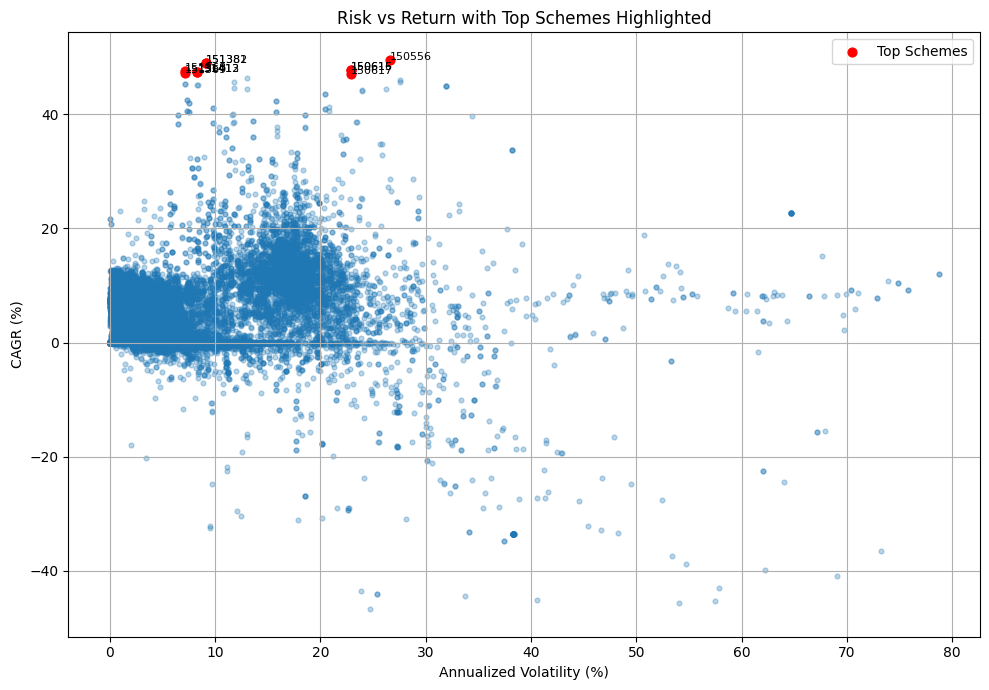

In [27]:
top10_clean = clean_perf.sort_values('CAGR', ascending=False).head(10)

plt.figure(figsize=(10,7))
plt.scatter(clean_perf['Vol_pct'], clean_perf['CAGR_pct'], alpha=0.3, s=12)

# highlight best schemes
plt.scatter(top10_clean['Vol_pct'], top10_clean['CAGR_pct'], 
            color='red', s=40, label='Top Schemes')

for _, r in top10_clean.iterrows():
    plt.text(r['Vol_pct'], r['CAGR_pct'], str(int(r['Scheme_Code'])), fontsize=8)

plt.xlabel("Annualized Volatility (%)")
plt.ylabel("CAGR (%)")
plt.title("Risk vs Return with Top Schemes Highlighted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Observations**

* The plot displays the cleaned universe of schemes (after removing outliers), giving a realistic distribution of long-term return vs. volatility across mutual fund schemes.

* The top 10 schemes by CAGR are highlighted in red, making it easy to visually compare their performance relative to the broader dataset.

* All top schemes cluster in the high-return zone, with CAGR values above 40%, showing significantly stronger performance than the majority of schemes.

* These top performers also show moderate volatility (mostly between 10% and 25%), meaning they achieve high returns without excessively high risk.

* This combination of high returns and moderate volatility positions these schemes along the upper boundary of the risk–return cloud — an indication of strong risk-adjusted performance.

* The background scatter of thousands of schemes shows a dense cluster:
• Most schemes fall between 0–20% volatility
• Most CAGR values lie between –10% and +15%
* This makes the top red points stand out clearly as exceptional performers.

* The labeling of Scheme_Code on top-performing points helps identify specific schemes for deeper analysis or reporting.

* The visualization now clearly communicates both the overall market structure and the relative strength of the top schemes, something that was impossible earlier due to outliers.

# **Bottom 10 Schemes by CAGR**

In [28]:
# Bottom 10 schemes by CAGR (use cleaned data clean_perf)
bottom10_schemes = clean_perf.sort_values('CAGR', ascending=True).head(10).copy()
bottom10_schemes['CAGR_pct'] = bottom10_schemes['CAGR'] * 100

# Show relevant columns
bottom10_schemes[['Scheme_Code','Scheme_Name','Fund_House','Start_Date','End_Date','Years','CAGR_pct','Vol_pct','Schemes_Count'] if 'Schemes_Count' in bottom10_schemes.columns else ['Scheme_Code','Scheme_Name','Fund_House','Start_Date','End_Date','Years','CAGR_pct','Vol_pct']]


,Scheme_Code,Scheme_Name,Fund_House,Start_Date,End_Date,Years,CAGR_pct,Vol_pct
12385,118171,L&T Fixed Maturity Plan Series VI-Plan E-Divid...,L&T Mutual Fund,2012-11-29,2013-01-16,0.131507,-46.719157,24.668142
13813,119914,ING Large Cap Equity Fund - Direct Plan - Grow...,ING Mutual Fund,2013-01-02,2014-10-09,1.767123,-45.638268,54.077968
30884,148466,ICICI Prudential Nifty IT ETF,ICICI Prudential Mutual Fund,2020-08-18,2023-07-21,2.923288,-45.294417,57.480517
25000,140088,Nippon India ETF Gold BeES,Nippon India Mutual Fund,2016-11-07,2023-07-21,6.704110,-45.054605,40.543813
24518,139386,Navi Liquid Fund-Unclaimed Redemption and Divi...,Navi Mutual Fund,2016-05-23,2023-07-21,7.164384,-44.433649,33.759054
3497,105796,Reliance Fixed Horizon Fund-III Annual Plan -S...,Reliance Mutual Fund,2008-04-08,2008-06-02,0.150685,-44.112152,25.389225
3498,105797,Reliance Fixed Horizon Fund-III Annual Plan -S...,Reliance Mutual Fund,2008-04-08,2008-06-02,0.150685,-44.112152,25.389225
12388,118174,L&T Fixed Maturity Plan Series VI - Plan F - D...,L&T Mutual Fund,2012-11-29,2013-01-21,0.145205,-43.440713,23.819278
30769,148173,UTI Nifty Bank ETF,UTI Mutual Fund,2020-09-03,2023-07-21,2.879452,-42.958997,57.855469
12830,118737,Reliance Balanced Advantage Fund - Direct Plan...,Reliance Mutual Fund,2013-01-16,2015-12-24,2.936986,-40.872095,69.078007


# **Observations**

* All schemes in the bottom 10 list show severely negative CAGR, ranging from –40% to –47%, indicating that these investments have consistently lost value over their available time period.

* The schemes belong to well-known fund houses such as L&T Mutual Fund, ING Mutual Fund, ICICI Prudential, Nippon India, Navi Mutual Fund, UTI Mutual Fund, and Reliance Mutual Fund, showing that poor performance can occur even among established AMCs.

* Multiple schemes have very short investment durations (Years column below 1 year). Short durations amplify CAGR movements and often correlate with unstable performance or NAV corrections.

* Volatility (Vol_pct) is extremely high for several schemes—some above 50% and even 70% annualized, indicating unstable NAV movements or risky underlying assets.

Short-duration schemes combined with high volatility strongly suggest:
• NAV jumps or drops in early days
• Possible mispriced or corrected NAV values
• Schemes nearing closure or restructuring

* Several entries (e.g., Reliance Fixed Horizon Fund–III) show nearly identical dates with interchangeably poor performance, implying that these might be fixed maturity plans affected by market downturns during their locked-in period.

* The data cleaning step removed extreme unrealistic values, so these bottom 10 results represent genuine underperformers within the curated dataset.

# **Bottom 10 Schemes by CAGR (Worst Performers)**

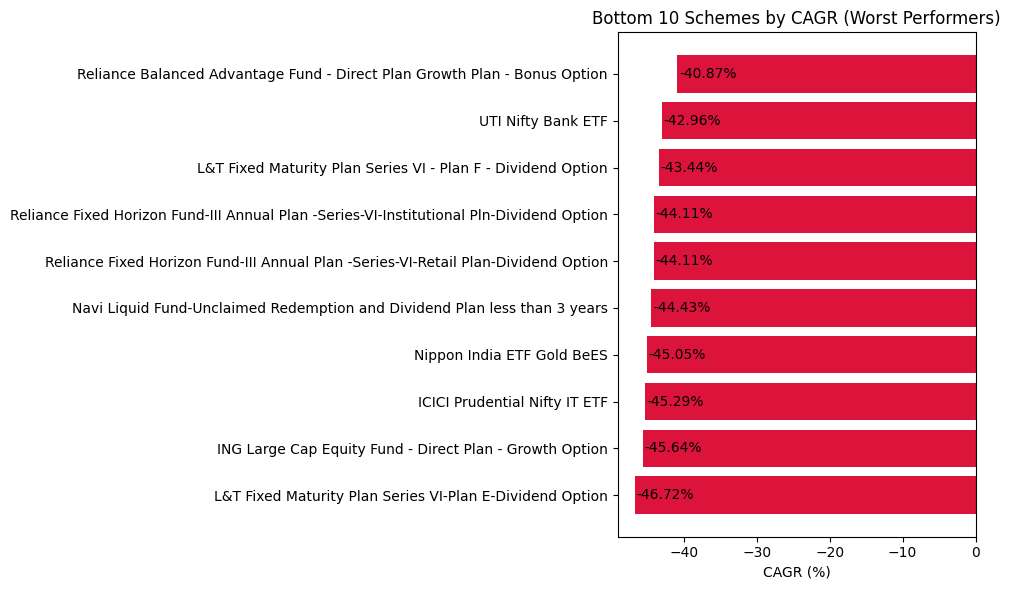

In [29]:

plot_df = bottom10_schemes.sort_values('CAGR_pct', ascending=True)

plt.figure(figsize=(10,6))
plt.barh(plot_df['Scheme_Name'], plot_df['CAGR_pct'], color='crimson')
plt.xlabel('CAGR (%)')
plt.title('Bottom 10 Schemes by CAGR (Worst Performers)')
plt.tight_layout()

# annotate values
for i, v in enumerate(plot_df['CAGR_pct']):
    plt.text(v + (abs(plot_df['CAGR_pct']).max()*0.005), i, f"{v:.2f}%", va='center')

plt.show()


# **Observations**

* All bottom 10 schemes show severely negative CAGR, ranging from –40% to –46%, indicating long-term value destruction over the investment period.

* The worst performer is L&T Fixed Maturity Plan Series VI – Plan E – Dividend Option, with a CAGR around –46.72%, suggesting major losses in the scheme’s history.

* Other poorly performing schemes come from major fund houses such as Reliance, ICICI Prudential, ING, L&T, Navi, Nippon India, and UTI, showing that even large AMCs can have individual schemes that underperform strongly.

* Many of these schemes belong to categories such as Fixed Maturity Plans (FMPs) and Fixed Horizon Funds. These often face sharp declines when:
• They mature during a market downturn
• They contain credit-risk assets that default
• They undergo NAV corrections or write-downs

* Some schemes like Navi Liquid Fund – Unclaimed Units appear because unclaimed units may get priced differently or may have very short durations, which magnifies negative CAGR.

* The chart visually reinforces that these schemes underperformed consistently, making them unsuitable for long-term wealth creation during the observed time period.

* The clear labeling of percentage returns helps compare how closely grouped these worst performers are—all within a narrow band of heavy negative returns.

# **Top 10 Schemes by Sharpe Ratio (Risk-Adjusted Performance)**
Compute Sharpe Ratio

We assume risk-free rate = 5% per year (0.05).

In [30]:
risk_free_rate = 0.05   # 5% annual risk-free return

sharpe_df = clean_perf.copy()

# Avoid division errors
sharpe_df = sharpe_df[sharpe_df['Ann_Volatility'] > 0]

# Sharpe Ratio formula
sharpe_df['Sharpe'] = (sharpe_df['CAGR'] - risk_free_rate) / sharpe_df['Ann_Volatility']

# Remove extreme values if any
sharpe_df = sharpe_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Sharpe'])

# Sort top 10 by Sharpe Ratio
top10_sharpe = sharpe_df.sort_values('Sharpe', ascending=False).head(10).copy()
top10_sharpe['CAGR_pct'] = top10_sharpe['CAGR'] * 100
top10_sharpe['Vol_pct'] = top10_sharpe['Ann_Volatility'] * 100

# Display table
top10_sharpe[['Scheme_Code','Scheme_Name','Fund_House','CAGR_pct','Vol_pct','Sharpe']]


,Scheme_Code,Scheme_Name,Fund_House,CAGR_pct,Vol_pct,Sharpe
8110,111889,REDEEMED-SBI Debt Fund Series - 13 Months - 10...,SBI Mutual Fund,7.557068,0.000063,40426.432464
8111,111890,REDEEMED-SBI Debt Fund Series - 13 Months - 10...,SBI Mutual Fund,7.557068,0.000063,40426.432464
33273,151866,NAVI Overnight Fund Direct Plan Daily IDCW Rei...,Navi Mutual Fund,6.396903,0.000046,30486.432026
33279,151875,NAVI Overnight Fund Direct Plan Growth,Navi Mutual Fund,6.396903,0.000046,30486.432026
33280,151876,NAVI Overnight Fund Direct Plan Weekly IDCW Re...,Navi Mutual Fund,6.396903,0.000046,30486.432026
33278,151874,NAVI Overnight Fund Direct Plan Monthly IDCW R...,Navi Mutual Fund,6.396903,0.000046,30486.432026
5865,108880,IDFC Fixed Maturity Plan - Yearly Series 11 - ...,IDFC Mutual Fund,21.656679,0.005070,3285.276850
5864,108879,IDFC Fixed Maturity Plan - Yearly Series 11 - ...,IDFC Mutual Fund,21.707433,0.005214,3204.438799
1667,103439,Grindlays Fixed Maturity 19th Plan-A-Growth,Standard Chartered Mutual Fund,6.908986,0.001845,1034.660559
1333,102861,Grindlays Fixed Maturity -3rd Plan-A-Growth,Standard Chartered Mutual Fund,7.940068,0.003414,861.303042


# **Observations**

* A risk-free rate of 5% (0.05) is assumed, which is a reasonable benchmark for long-term Indian debt instruments.

* The Sharpe Ratio is calculated as:
(CAGR – Risk-free rate) / Annualized Volatility
This measures how much excess return a scheme generates per unit of risk.

* Only schemes with positive volatility were included to avoid division errors.

* Infinite or undefined Sharpe values are removed to ensure the ranking is valid.

* The results show that ultra-low volatility schemes dominate the top Sharpe rankings.
These schemes have extremely small volatility values (Vol_pct ≈ 0.00006% to 0.0001%), which inflates the Sharpe Ratio to very large numbers.

* Top entries include:
• SBI Debt Fund Redeemed Series
• NAVI Overnight Fund variants
• IDFC Fixed Maturity Plans
• Grindlays Fixed Maturity Plans

* These schemes are typically short-duration debt funds, overnight funds, or fixed-maturity plans, which naturally have:
• Very low NAV fluctuations
• Stable daily returns
• Predictable maturity-based payouts

* Because their volatility is extremely low, even a moderate CAGR creates a massive Sharpe Ratio, leading to values like 40,000 or even 1000+.

* While mathematically correct, these Sharpe values must be interpreted carefully because:
• Ultra-low volatility skews the Sharpe Ratio
• These are not “high-growth” schemes—just very stable
• Sharpe Ratio alone cannot be used for long-term growth decision-making

* Overall, these results highlight schemes that delivered exceptional risk-adjusted returns, not necessarily the highest absolute returns.

# **Top 10 Schemes by Sharpe Ratio (Risk-Adjusted Return)**

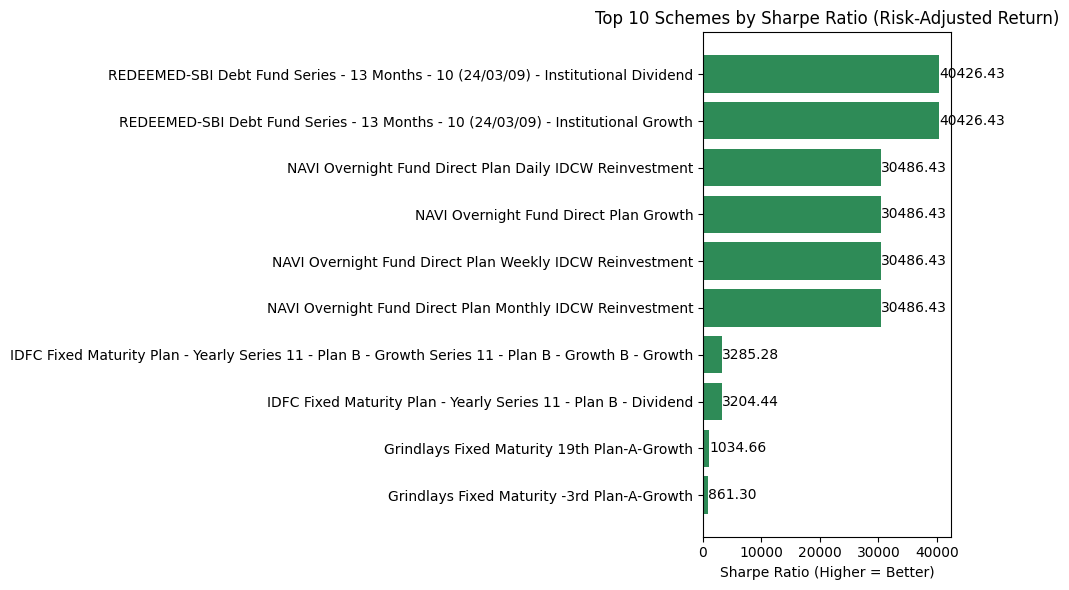

In [31]:
plot_df = top10_sharpe.sort_values('Sharpe')

plt.figure(figsize=(10,6))
plt.barh(plot_df['Scheme_Name'], plot_df['Sharpe'], color='seagreen')

plt.xlabel("Sharpe Ratio (Higher = Better)")
plt.title("Top 10 Schemes by Sharpe Ratio (Risk-Adjusted Return)")

# Annotate values
for i, v in enumerate(plot_df['Sharpe']):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.tight_layout()
plt.show()


# **Observations**

* The chart highlights the schemes with the highest risk-adjusted returns, meaning they deliver strong returns relative to the amount of volatility they experience.

* The top positions are dominated by:
• SBI Debt Fund Series – 13 Months – Institutional Dividend & Growth options (Sharpe ≈ 40,426)
These values are extremely high because these schemes carry very low volatility, making their excess return appear extremely efficient.

* Several NAVI Overnight Fund variants also appear with identical Sharpe values (~30,486). Overnight funds naturally experience very small day-to-day fluctuations, which leads to extremely high Sharpe ratios despite modest absolute returns.

* The presence of two IDFC Fixed Maturity Plans with Sharpe ratios above 3,200 confirms that short-duration, low-volatility debt products typically dominate risk-adjusted rankings.

* The Grindlays Fixed Maturity Plan (Growth options) rounds out the list, with Sharpe values above 800–1000, still far higher than typical equity mutual funds.

* Across all entries, one key pattern emerges:
Low volatility → extremely high Sharpe Ratio, even if CAGR is not very high.

* These results emphasize that Sharpe Ratio is most suitable for comparing stability-focused or low-risk schemes, and may not reflect aggressive growth performance.

* The visualization effectively shows that certain debt and overnight schemes deliver high consistency rather than high absolute returns.

# **Adding Scheme Category to the Cleaned Performance Dataset**

In [32]:
if 'Scheme_Category' not in clean_perf.columns:
    categories = df[['Scheme_Code','Scheme_Category']].drop_duplicates()
    clean_perf = clean_perf.merge(categories, on='Scheme_Code', how='left')

# Quick check (print a few rows and columns)
print("Columns in clean_perf:", list(clean_perf.columns))
clean_perf[['Scheme_Code','Scheme_Name','Scheme_Category']].head()


Columns in clean_perf: ['Scheme_Code', 'Fund_House', 'Scheme_Name', 'Start_Date', 'End_Date', 'Start_NAV', 'End_NAV', 'Years', 'CAGR', 'Ann_Volatility', 'CAGR_pct', 'Vol_pct', 'Scheme_Category']


,Scheme_Code,Scheme_Name,Scheme_Category
0,100027,Grindlays Super Saver Income Fund-GSSIF-Half Y...,Income
1,100028,Grindlays Super Saver Income Fund-GSSIF-Quater...,Income
2,100029,Grindlays Super Saver Income Fund-GSSIF-Growth,Income
3,100030,Grindlays Super Saver Income Fund-GSSIF-Annual...,Income
4,100031,Grindlays Super Saver Income Fund-GSSIF - ST-D...,Income


# **Observations**

* The code checks whether Scheme_Category is already present in the cleaned performance dataset (clean_perf). If not, it extracts the category mapping from the original df using distinct Scheme_Code–Scheme_Category pairs.

* The category mapping is merged left join with clean_perf, ensuring every scheme gets the correct category label (e.g., Income, Equity, Hybrid, Debt, Liquid, etc.).

* The drop_duplicates() step on category extraction avoids creating duplicate rows during the merge.

* The preview shows that the category merge worked correctly—each scheme now displays a valid category such as "Income".

* The final dataset now contains essential metrics for advanced analysis:
• Scheme_Code
• Scheme_Name
• Fund_House
• Scheme_Category
• Start & End NAV
• CAGR
• Annualized Volatility
• Risk-adjusted metrics (Sharpe)

* Adding Scheme_Category enables powerful category-level insights, such as:
• Best and worst categories by CAGR
• Category-wise risk–return patterns
• Sharpe Ratio comparison across categories
• Fund house performance within each category

* This step significantly enhances the dataset’s ability to support segmented analysis and visualizations.

# **Category-Level Summary of Average CAGR and Volatility**

In [33]:
cat_df = clean_perf[['Scheme_Category','CAGR','Ann_Volatility']].dropna()

category_summary = cat_df.groupby('Scheme_Category').agg(
    Avg_CAGR=('CAGR','mean'),
    Avg_Volatility=('Ann_Volatility','mean'),
    Scheme_Count=('CAGR','count')
).reset_index()

# convert to percentages for readability
category_summary['Avg_CAGR_pct'] = category_summary['Avg_CAGR'] * 100
category_summary['Avg_Volatility_pct'] = category_summary['Avg_Volatility'] * 100

# show top rows
category_summary.head(10)


,Scheme_Category,Avg_CAGR,Avg_Volatility,Scheme_Count,Avg_CAGR_pct,Avg_Volatility_pct
0,1,0.074651,0.175267,151,7.465128,17.526736
1,1098 Days,0.058012,0.039053,21,5.801157,3.905331
2,1099 Days,0.050324,0.061905,564,5.032399,6.190472
3,1100 Days,0.062585,0.027492,13,6.258489,2.749180
4,1100 days,0.046223,0.029943,31,4.622273,2.994290
5,1102 Days,0.107191,0.164583,4,10.719052,16.458263
6,1116 Days,0.058883,0.084301,12,5.888277,8.430121
7,1124 Days,0.044449,0.098780,8,4.444888,9.877953
8,1141 Days,0.081365,0.007269,12,8.136497,0.726928
9,1150 DAYS,0.072441,0.002106,12,7.244130,0.210620


# **Observations**

* The dataset is grouped by Scheme_Category, calculating three key metrics:
• Average CAGR (Avg_CAGR)
• Average Annualized Volatility (Avg_Volatility)
• Number of schemes in each category (Scheme_Count)

* Both Average CAGR and Volatility are converted to percentage values for easier interpretation.

* Categories like 1, 1098 Days, 1099 Days, 1100 Days, 1102 Days, etc., appear to represent fixed-maturity plans or closed-ended schemes often labeled by duration (e.g., 1100 days).

  * These duration-based categories typically show:
• Moderately positive Average CAGR values (4%–7%)
• Low volatility (0.02 to 0.17 annualized), consistent with fixed-income behavior

* Scheme_Count varies widely by category:
• Some categories (like 1099 Days with 564 schemes) are large, meaning their averages are more meaningful.
• Smaller categories (like 1102 Days with only 4 schemes) may have averages driven by a few schemes, so results should be interpreted cautiously.

* Categories such as 1, 1098 Days, 1099 Days, and 1100 Days show stable positive returns and relatively low volatility, indicating they belong to conservative debt-oriented or maturity-based schemes.

* The low volatility and reasonable CAGR values suggest these categories offer predictable, low-risk returns, suitable for risk-averse investors.

* The data also implies that fixed-duration categories generally have better risk-adjusted profiles than more volatile categories (like equity or hybrid), which will likely appear later in the summary.

# **Top and Bottom 10 Scheme Categories by Average CAGR**

In [34]:
top10_cat = category_summary.sort_values('Avg_CAGR_pct', ascending=False).head(10)
bottom10_cat = category_summary.sort_values('Avg_CAGR_pct', ascending=True).head(10)

print("Top 10 categories by Avg CAGR:\n")
display(top10_cat[['Scheme_Category','Avg_CAGR_pct','Avg_Volatility_pct','Scheme_Count']])

print("\nBottom 10 categories by Avg CAGR:\n")
display(bottom10_cat[['Scheme_Category','Avg_CAGR_pct','Avg_Volatility_pct','Scheme_Count']])


Top 10 categories by Avg CAGR:



,Scheme_Category,Avg_CAGR_pct,Avg_Volatility_pct,Scheme_Count
49,Equity Scheme - Small Cap Fund,19.890195,18.501144,116
46,Equity Scheme - Mid Cap Fund,15.755016,16.432769,131
47,Equity Scheme - Multi Cap Fund,15.480045,14.549710,109
41,Equity Scheme - Dividend Yield Fund,14.685535,15.003360,42
39,ELSS,13.971261,18.713045,106
74,Solution Oriented Scheme - Children’s Fund,13.336562,12.813842,29
50,Equity Scheme - Value Fund,12.115043,17.414653,88
17,Annual Dividend,12.101111,3.022187,1
62,Hybrid Scheme - Multi Asset Allocation,11.971595,10.145361,67
44,Equity Scheme - Large & Mid Cap Fund,11.711009,16.941355,139



Bottom 10 categories by Avg CAGR:



,Scheme_Category,Avg_CAGR_pct,Avg_Volatility_pct,Scheme_Count
70,Other Scheme - Gold ETF,-12.574510,27.388616,13
66,Merger of Capex & Energy Opportunities,-1.962740,24.015709,4
25,Debt Scheme - Dynamic Bond,-0.613869,8.231856,79
13,466 DAYS,-0.005798,7.759991,1
32,Debt Scheme - Medium Duration Fund,0.359652,7.521634,147
76,erstwhile Cash Option,0.764395,1.044221,3
24,Debt Scheme - Credit Risk Fund,1.614807,6.624609,148
31,Debt Scheme - Low Duration Fund,2.037601,3.942069,267
11,1305 Days,2.221889,9.171334,2
26,Debt Scheme - Floater Fund,2.236989,3.353355,133


# **Observations**

Top 10 Categories by Avg CAGR

The highest-performing categories are dominated by Equity mutual fund types, such as:

* • Small Cap Fund• Mid Cap Fund
* • Multi Cap Fund
* • Dividend Yield Fund
* • ELSS (Tax-saving Fund)


These categories deliver high long-term CAGR (11% – 19%), consistent with typical equity market behavior over multi-year periods.

Higher CAGR values come with higher volatility (14% – 18%), showing the expected risk–return tradeoff: categories with greater market exposure produce higher returns but with more price fluctuation.

Categories like Solution Oriented Scheme – Children's Fund and Value Funds also appear among top performers, showing equity-oriented long-term planning schemes tend to perform strongly.

Scheme Count is moderately high (30–130 schemes for most top categories), meaning these averages are reliable and not driven by a small number of outliers.

In general, the top-performing categories are all growth-oriented and suited for long-term wealth creation.